**Task 2 : Reconstructing using Random Fourier Features (RFF) [3 marks]**

**2.** Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time
(
t
)
 to amplitude
(
A
)
, where
t
 is the time point, and
A
 is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [ ]:
import torchaudio

file_path = '/content/claps-44774.mp3'

try:
    audio, sr = torchaudio.load(file_path)
except RuntimeError as e:
    print(f"Error loading audio: {e}")

print(f"Loaded audio shape: {audio.shape}, Sample rate: {sr} Hz")


Loaded audio shape: torch.Size([2, 114048]), Sample rate: 24000 Hz


In [ ]:
audio = audio[0]
print(f"Audio shape after selecting first channel: {audio.shape}")

Audio shape after selecting first channel: torch.Size([114048])


In [ ]:
tm = len(audio) / sr  # len(audio) gives the number of samples in 1D
print(f"Audio length: {tm} seconds")

Audio length: 4.752 seconds


In [ ]:
audio

tensor([ 0.0000e+00,  2.0998e-16, -2.4791e-17,  ..., -2.2997e-08,
        -6.3079e-09, -6.0046e-08])

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

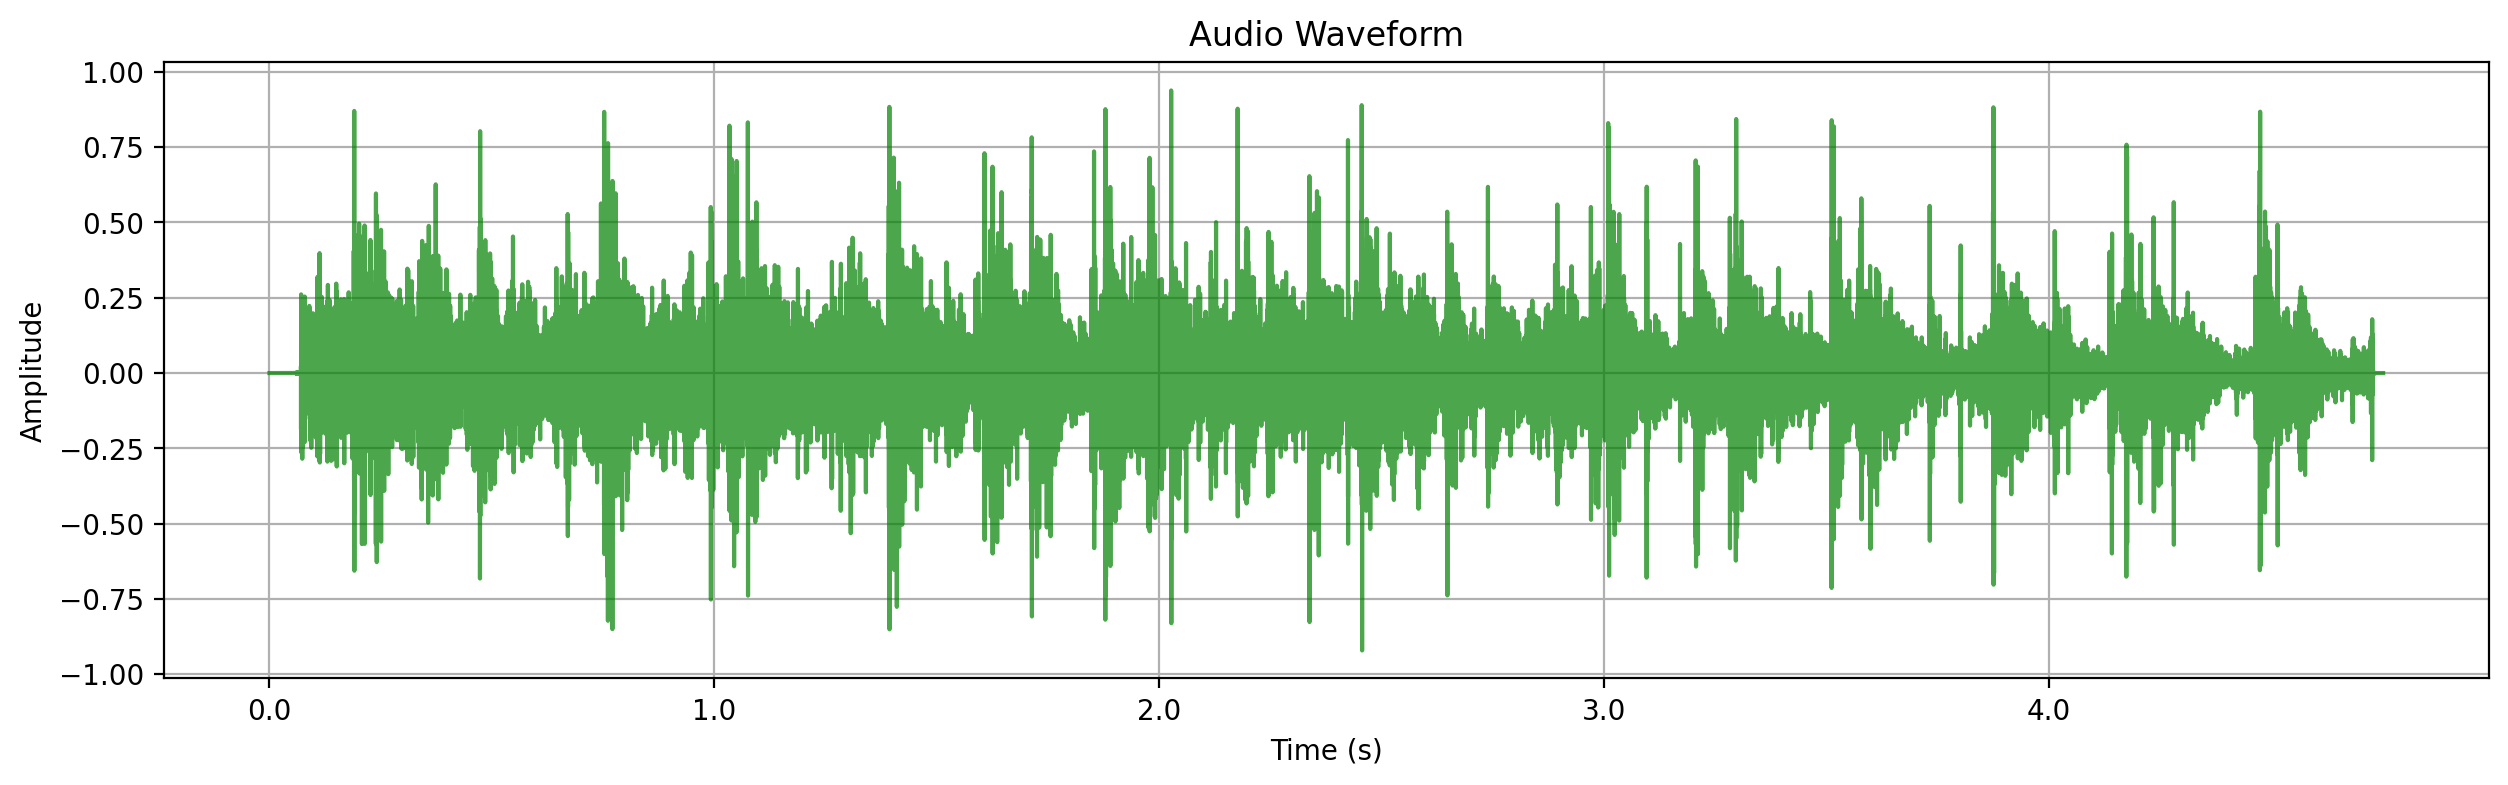

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([114048, 1])
tensor([[-100.0000],
        [ -99.9982],
        [ -99.9965],
        ...,
        [  99.9965],
        [  99.9982],
        [ 100.0000]])


In [ ]:
Audio(audio, rate = sr)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for reproducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([114048, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0059, -0.0191, -0.0190,  ..., -0.0197,  0.0088, -0.0082],
        [ 0.0029, -0.0198, -0.0189,  ..., -0.0199,  0.0104, -0.0109],
        ...,
        [-0.0127, -0.0199, -0.0147,  ...,  0.0050, -0.0032, -0.0101],
        [-0.0102, -0.0194, -0.0145,  ...,  0.0059, -0.0013, -0.0126],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(114048,)


In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
print(pred_audio)
print(audio)

[-0.05049553 -0.03583707 -0.02248719 ...  0.08150987  0.08093372
  0.07575609]
tensor([ 0.0000e+00,  2.0998e-16, -2.4791e-17,  ..., -2.2997e-08,
        -6.3079e-09, -6.0046e-08])


In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(37.00607, 9043.739)

In [ ]:
Audio(pred_audio, rate = sr)

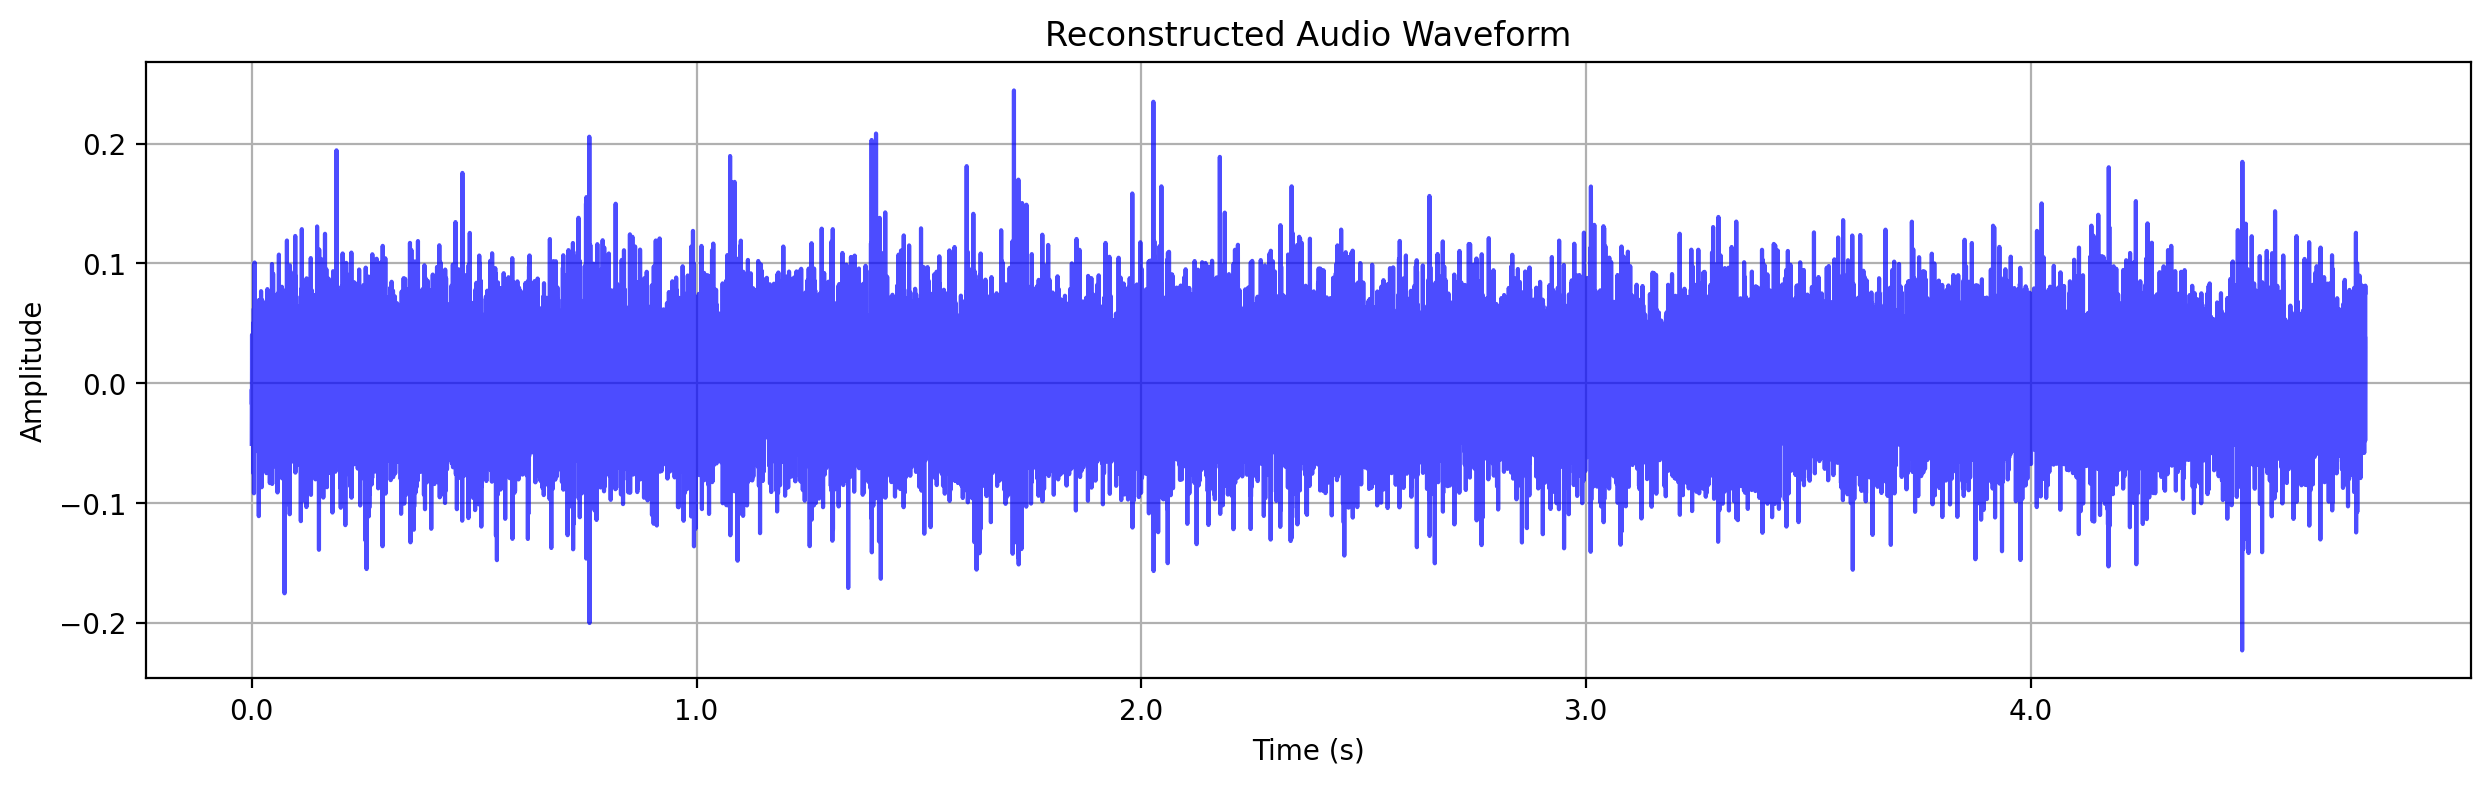

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

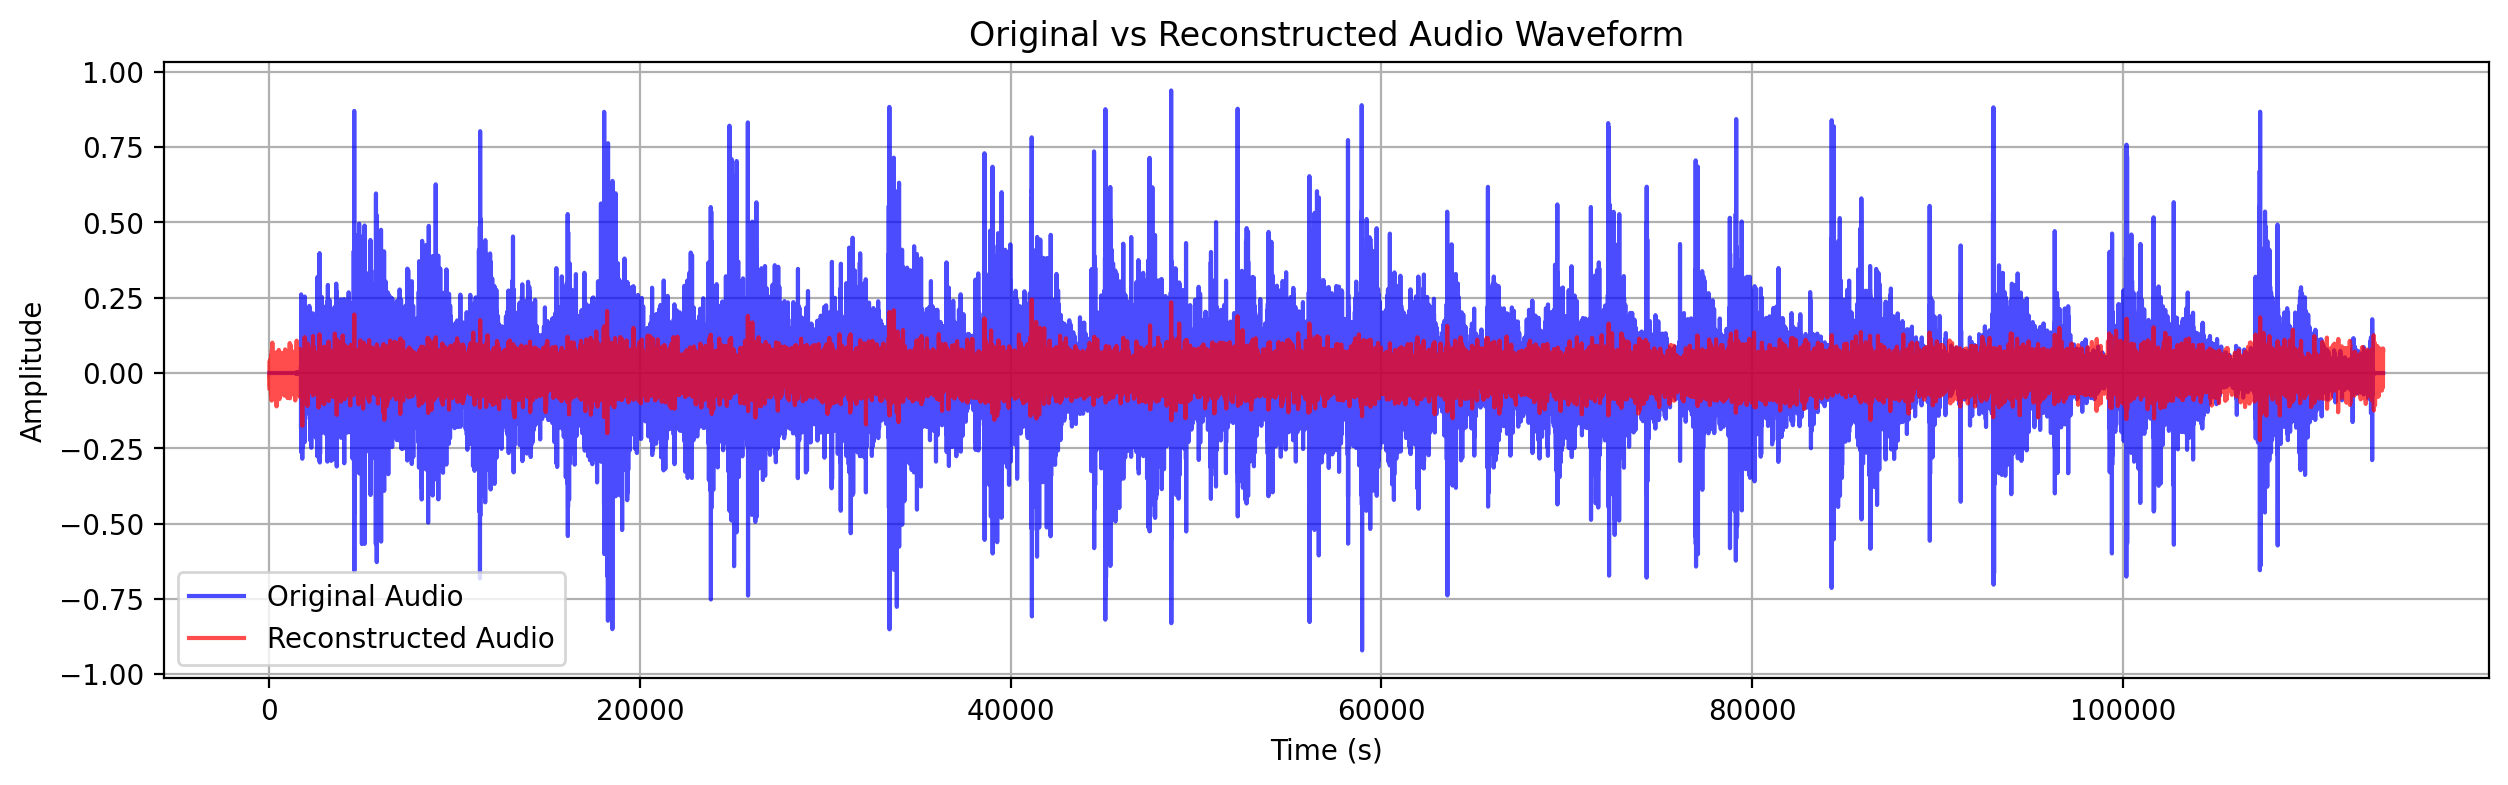

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(audio.numpy(), pred_audio))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# SNR (Signal-to-Noise Ratio)
signal_power = np.mean(audio.numpy() ** 2)
noise_power = np.mean((audio.numpy() - pred_audio) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

Root Mean Squared Error (RMSE): 0.10957945138216019
Signal-to-Noise Ratio (SNR): 0.5618061497807503 dB


**Task 3 : Super-Resolution using Random Fourier Features (RFF) [4 Marks]**

**1.**Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
import os
from PIL import Image
from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing

# Set env CUDA_LAUNCH_BLOCKING=1 and device
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display for better quality images
%config InlineBackend.figure_format = 'retina'

# Install einops if necessary
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [ ]:
# Check if the image exists, if not download it
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg


--2024-09-20 12:14:59--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.64.236.6, 18.64.236.19, 18.64.236.71, ...
Connecting to segment-anything.com (segment-anything.com)|18.64.236.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-20 12:14:59 (5.51 MB/s) - ‘dog.jpg’ saved [221810/221810]



torch.Size([3, 1365, 2048])


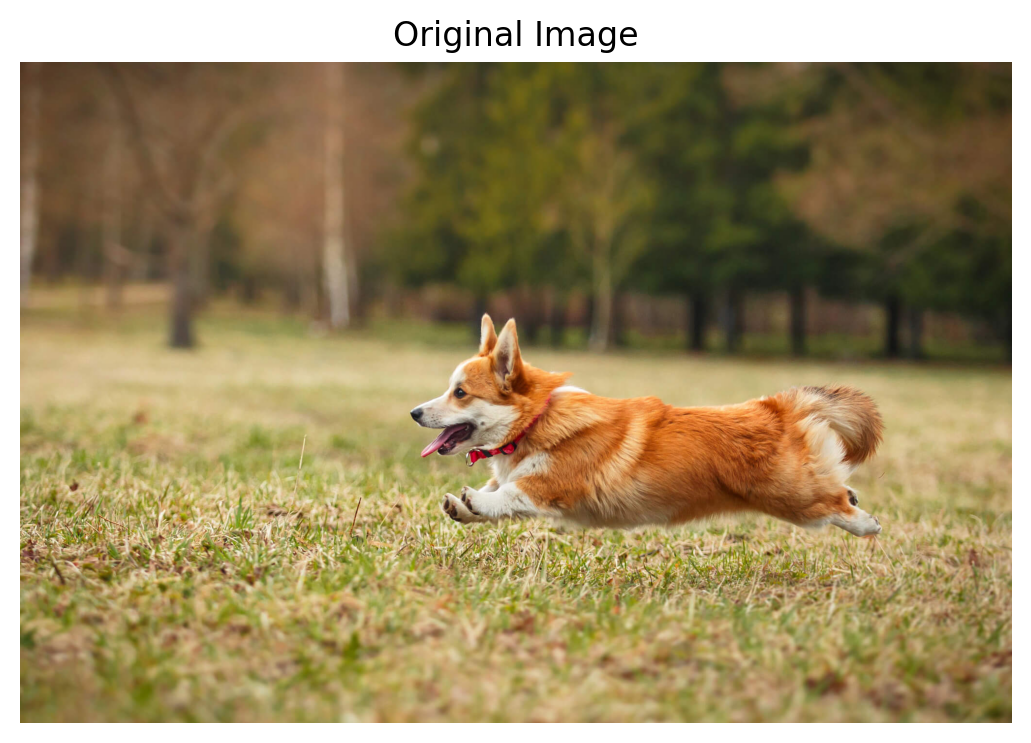

In [ ]:
# Read the image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)  # Check the image shape
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Crop the image to 400x400 (the high-resolution version)
crop = torchvision.transforms.functional.crop(img, 600, 800, 400, 400)
print(f"Cropped Image Shape (400x400): {crop.shape}")

Cropped Image Shape (400x400): torch.Size([3, 400, 400])


In [ ]:
# Convert the cropped image to float and normalize the pixel values
img_scaled = crop.float() / 255.0
img_scaled = img_scaled.to(device)

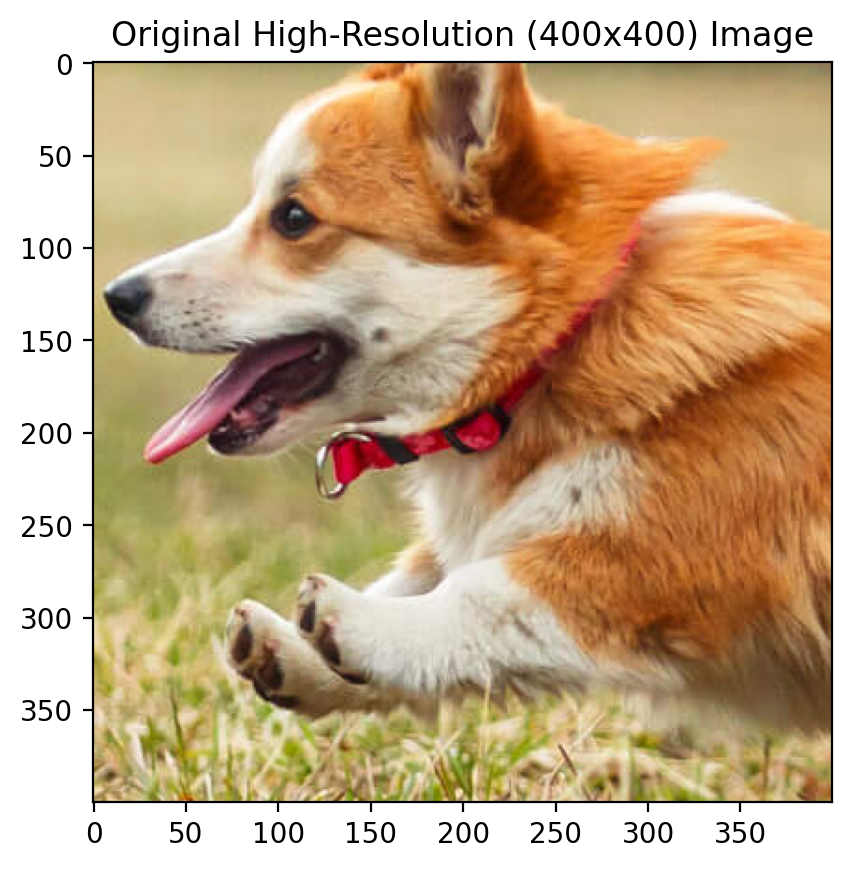

In [ ]:
# Normalize the cropped image if needed
crop_normalized = crop / crop.max()  # Ensure the values are between 0 and 1

# Display the cropped high-resolution image
plt.imshow(rearrange(crop_normalized, 'c h w -> h w c').cpu().numpy())
plt.title("Original High-Resolution (400x400) Image")
plt.show()

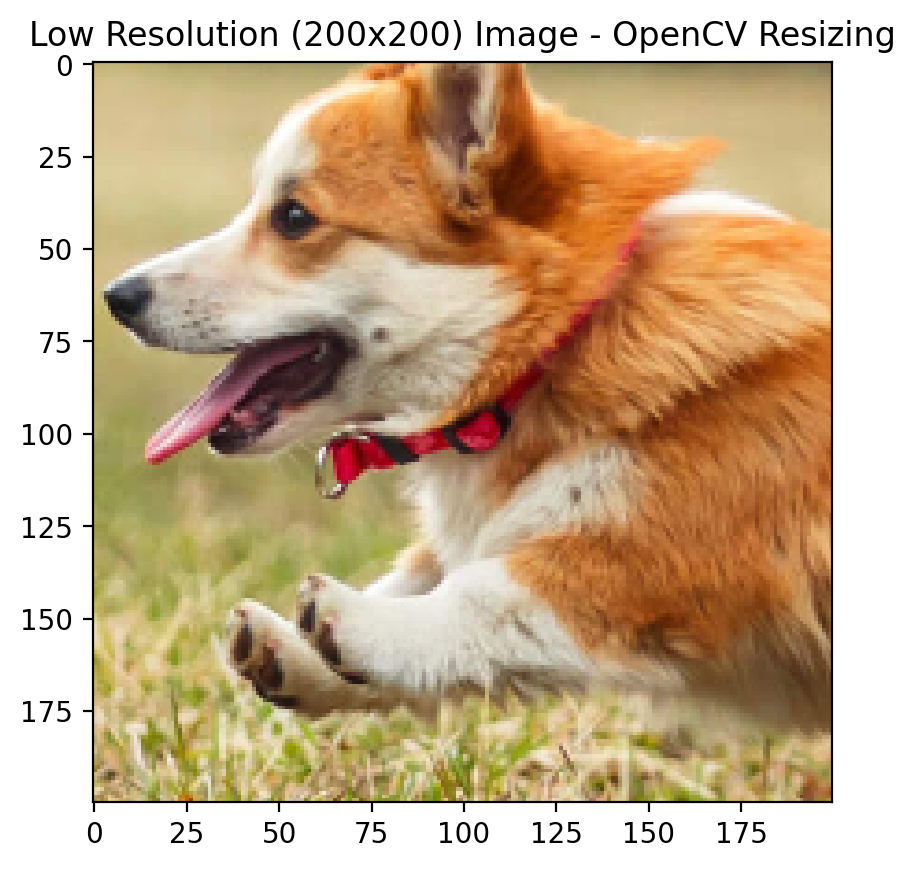

In [ ]:
import cv2
import torch

# Convert the image tensor to a NumPy array and rearrange it for OpenCV (from CHW to HWC)
img_np = rearrange(crop, 'c h w -> h w c').cpu().numpy()

# Resize the 400x400 image to 200x200 using OpenCV's resize function
low_res_image_cv2 = cv2.resize(img_np, (200, 200), interpolation=cv2.INTER_AREA)
low_res_image_cv2 = low_res_image_cv2 / 255.0  # Normalize the pixel values

# Convert the resized image back to a tensor and rearrange it back to CHW (from HWC)
low_res_image_cv2_tensor = torch.tensor(rearrange(low_res_image_cv2, 'h w c -> c h w')).float().to(device)

# Display the low-resolution image resized using OpenCV
plt.imshow(low_res_image_cv2)
plt.title("Low Resolution (200x200) Image - OpenCV Resizing")
plt.show()

In [ ]:
num_channels, height, width = crop.shape
print(f"Original Cropped Image Shape: {num_channels} {height} {width}")


Original Cropped Image Shape: 3 400 400
Resized Image Shape: 3 200 200


In [ ]:
num_channels, height, width = low_res_image_cv2_tensor.shape
print(f"Resized Image Shape: {num_channels} {height} {width}")

In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
X.shape

torch.Size([12, 2])

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
low_res_image_cv2_X, low_res_image_cv2_Y = create_coordinate_map(low_res_image_cv2_tensor)
print(low_res_image_cv2_X.shape, low_res_image_cv2_Y.shape)

torch.Size([40000, 2]) torch.Size([40000, 3])


In [ ]:
from sklearn import preprocessing
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_image_cv2_X.cpu())
scaler_Y = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_image_cv2_Y.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(low_res_image_cv2_X.cpu())

# Scale the Y coordinates
dog_Y_scaled = scaler_Y.transform(low_res_image_cv2_Y.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_Y_scaled = torch.tensor(dog_Y_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
dog_Y_scaled = dog_Y_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
X_rff = create_rff_features(dog_X_scaled, 3000, 0.008)

In [ ]:
X_rff.shape

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

**2.**The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Flatten the original and predicted images for RMSE computation
original_flat = original_400x400.reshape(-1, 3)
predicted_flat = predicted_400x400.reshape(-1, 3)

# Compute RMSE between the predicted and ground truth high-resolution image
rmse = np.sqrt(mean_squared_error(original_flat, predicted_flat))
print(f"RMSE: {rmse}")

In [ ]:
import math

# Compute PSNR between predicted and original images
def compute_psnr(original, predicted, max_pixel_value=1.0):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:  # Avoid division by zero
        return float('inf')
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
    return psnr

psnr = compute_psnr(original_400x400, predicted_400x400)
print(f"PSNR: {psnr} dB")
